# Image Classification and Object Localization

In this notebook, we build a CNN from scratch to:
- classify the main subject in an image
- localize it by drawing bounding boxes around it.

We will be using MNIST dataset to syenthesize a custom dataset for the task.

# Imports

In [1]:
import os , re , time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.14.0


In [3]:
import sys
print(sys.version)


3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


# Visualization Utilities
These function are used to draw bounding box.

In [4]:
# Size of image
im_width = 75
im_height = 75

def draw_bounding_boxes_on_image_array(image,boxes,color=[],thickness=1,display_string_list=()):   # Draw bounding box on images(numpy array)
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGB",image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_image(rgbimg,boxes, color, thickness,display_string_list)

    return np.array(rgbimg)

def draw_bounding_boxes_image(image, boxes,color,thickness, display_string_list=()):     # draw bounding box on image
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) !=2 or boxes_shape[1] !=4:
        raise ValueError('Input must be of size [N,4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image,boxes[i,1],boxes[i,0],boxes[i,3],boxes[i,2],color[i],thickness,display_string_list[i])

def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color='red',thickness=1,display_string=None,use_normalized_coordinates=True):
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left,right,top,bottom) = (xmin * im_width,xmax * im_width,
                                   ymin * im_height, ymax * im_height)
    else:
        (left,right,top,bottom) = (xmin,xmax,ymin,ymax)
    draw.line([(left,top),(left,bottom),(right,top),(right,bottom)],width=thickness,fill=color)




### Utilities to Visualize data and predixtions

In [5]:
# Matplotlib configuration
plt.rc('image',cmap='gray')
plt.rc('grid',linewidth=0)
plt.rc('xtick',top=False,bottom=False,labelsize='large')
plt.rc('ytick',left=False,right=False,labelsize='large')
plt.rc('axes',facecolor='F8F8F8', titlesize='large',edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure',facecolor='F0F0F0')
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__),"mpl-data/fonts/ttf")

In [6]:
# pUlling a batch from the datasets.
def dataset_to_numpy_util(training_dataset,validation_dataset,N):
    # getting one batch from each: 10000 validataion digits, N training digits
    batch_train_ds = training_dataset.unbatch().batch(N)

    # eager execution: looping through datasets
    if tf.executing_eagerly():
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break
        for training_digits, (training_labels, training_bboxes) in batch_train_ds:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break

    validation_labels = np.argmax(validation_labels, axis = 1)
    training_labels = np.argmax(training_labels, axis = 1)

    return (training_digits, training_labels, training_bboxes, validation_digits, validation_labels,validation_bboxes)


In [7]:
# create digits from local fonts for testing
def crete_difgits_from_local_fronts(n):
    font_labels=[]
    img = PIL.Image.new('LA', (75*n,75),color = (0,255)) # LA : black in channel 0,alpha in channel 1
    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR,'DejaVuSansMono-Oblique.ttf'),25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR,'STIXGeneral.tff'),25)
    d = PIL.ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i%10)
        d.text((7+i*75,0 if i<10 else -4),str(i%10),fill=(255,255),font=font1 if i<10 else font2)
        font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0
        font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits,[75,75*n]),n,axis=1),axis=0),[n,75*75])
        return font_digits, font_labels

In [8]:
# utility to display a row of digits with their predictinos
def display_digits_with_boxes(digits, predictions, labels,pred_bboxes,bboxes,iou, title):

    n = 10

    indexes = np.random.choice(len(predictions),size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    if len(pred_bboxes) > 0:
        n_pred_bboxes = pred_bboxes[indexes,:]
    if len(bboxes) > 0:
        n_bboxes = bboxes[indexes,:]

    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n,75,75)
    fig = plt.figure(figsize=(20,4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax =fig.add_subplot(1,10,i+1)
        bboxes_to_plot = []
        if len(pred_bboxes) > i:
            bboxes_to_plot.append(n_pred_bboxes[i])
        if len(bboxes) > i:
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i],boxes=np.asarray(bboxes_to_plot),color=['red','green'],display_string_list=['true','pred'])
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])

        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color('red')

        plt.imshow(img_to_draw)

        if len(iou) > i :
            color = 'black'
            if (n_iou[i][0] < iou_threshold):
                color = 'red'
            ax.text(0.2,-0.3,'iou: %s' %(n_iou[i][0]),color,transform=ax.transAxes)


In [11]:
# utility to display training and validation curves
def plot_metrics(metric_name, title,ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_'+metric_name)

In [16]:
BATCH_SIZE = 64

# Loading and Preprocessing the dataset

In [17]:
# function randomly overlays the 'digit' image on top of a larger canvas
# transforms each image in dataset by pasting it on a 75x75 canvas at random locations.

def read_image_tfds(image, label):
    xmin = tf.random.uniform((),0,48,dtype=tf.int32)
    ymin = tf.random.uniform((),0,48,dtype=tf.int32)
    image = tf.reshape(image,(28,28,1,))
    image = tf.image.pad_to_bounding_box(image,ymin,xmin,75,75)
    image = tf.cast(image,tf.float32)/255.0
    xmin = tf.cast(xmin,tf.float32)
    ymin = tf.cast(ymin,tf.float32)

    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label,10),[xmin,ymin,xmax,ymax])


In [18]:
# Loads the data and splits it to get the training set
def get_training_dataset():
    dataset = tfds.load('mnist',split='train',as_supervised=True,try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(5000,reshuffle_each_iteration = True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1)       # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset


In [19]:
# loads tha data and split data to get the validation set
def get_validation_dataset():
  dataset = tfds.load('mnist',split='test',as_supervised=True,try_gcs=True)
  dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
  dataset = dataset.batch(10000)
  dataset = dataset.repeat()
  return dataset


In [20]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

## Visualize dataset

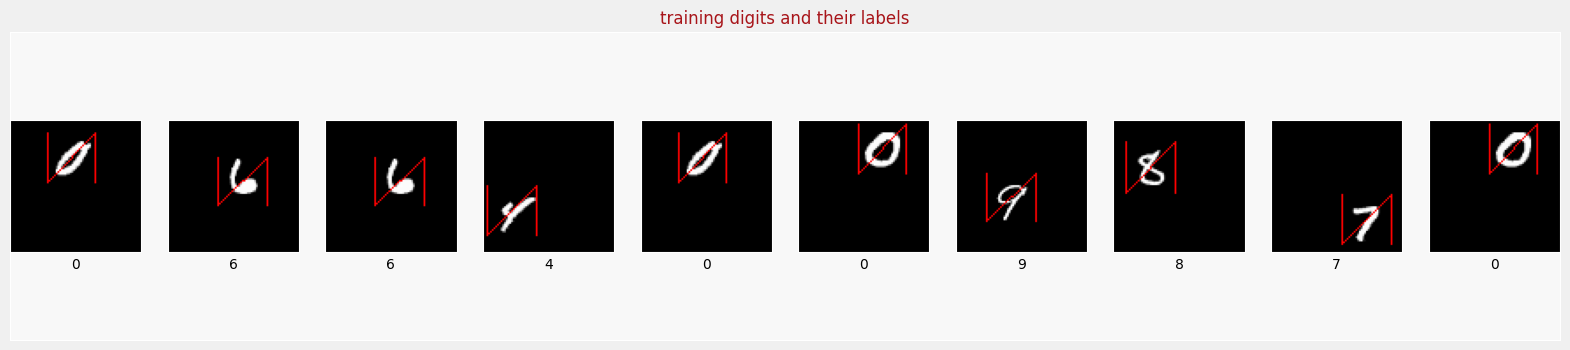

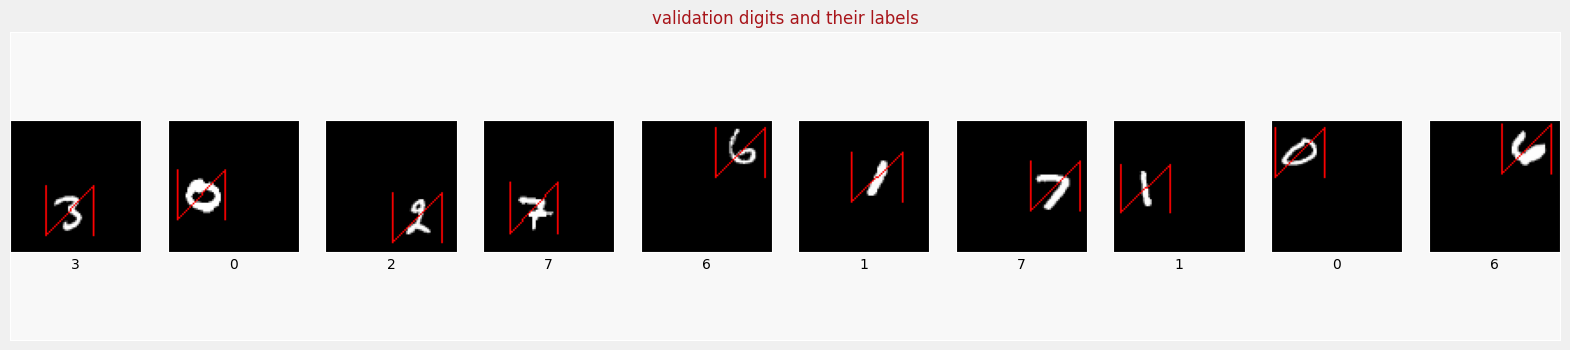

In [21]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels,validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)

display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "training digits and their labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]), validation_bboxes, np.array([]), "validation digits and their labels")

# Custom CNN Model

In [22]:
# Feature Extractor : these Convolutional layers extract features of image

def feature_extractor(inputs):
  x = tf.keras.layers.Conv2D(16,activation='relu',kernel_size=3,input_shape=(75,75,1))(inputs)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  return x


In [23]:
# dense layer adds a flatten and a dense layer
def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  return x

In [24]:
# Classifier: define the output layer that predict among 10 categories (0 to 9 digits)
def classifier(inputs):

  classification_output = tf.keras.layers.Dense(10, activation='softmax', name = 'classification')(inputs)
  return classification_output


In [25]:
# bounding_box_regression: this defines the output layer that predicts 4 numeric values,
#   which define the coordinates of the bounding box ( xmin,ymin,xmax,ymax)
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output


In [26]:
# final model: This combines the layers for feature extraction, classification and bounding box prediction.
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model


In [27]:
# Compile the model
def define_and_compile_model(inputs):
  model = final_model(inputs)

  model.compile(optimizer='adam',
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })
  return model

In [28]:
inputs = tf.keras.layers.Input(shape=(75,75,1,))
model=define_and_compile_model(inputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 73, 73, 16)           160       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 36, 36, 16)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 34, 34, 32)           4640      ['average_pooling2d[0][0]'

## Train and Validate the model

In [29]:
from tensorflow_datasets.core.features import bounding_boxes
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE
validation_steps = 1

history = model.fit(training_dataset,steps_per_epoch=steps_per_epoch,validation_data=validation_dataset,
                    validation_steps=validation_steps,epochs=EPOCHS)
loss, classification_loss,bounding_box_loss,classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset,steps=1)
print("Validation accuracy: ",classification_accuracy)

Epoch 1/10
937/937 [==============================] - 39s 28ms/step - loss: 0.9625 - classification_loss: 0.9488 - bounding_box_loss: 0.0137 - classification_accuracy: 0.6683 - bounding_box_mse: 0.0137 - val_loss: 0.3058 - val_classification_loss: 0.2984 - val_bounding_box_loss: 0.0074 - val_classification_accuracy: 0.9072 - val_bounding_box_mse: 0.0074
Epoch 2/10
937/937 [==============================] - 14s 15ms/step - loss: 0.2668 - classification_loss: 0.2610 - bounding_box_loss: 0.0058 - classification_accuracy: 0.9210 - bounding_box_mse: 0.0058 - val_loss: 0.1755 - val_classification_loss: 0.1718 - val_bounding_box_loss: 0.0036 - val_classification_accuracy: 0.9495 - val_bounding_box_mse: 0.0036
Epoch 3/10
937/937 [==============================] - 18s 19ms/step - loss: 0.1961 - classification_loss: 0.1927 - bounding_box_loss: 0.0035 - classification_accuracy: 0.9414 - bounding_box_mse: 0.0035 - val_loss: 0.1427 - val_classification_loss: 0.1400 - val_bounding_box_loss: 0.0027 -

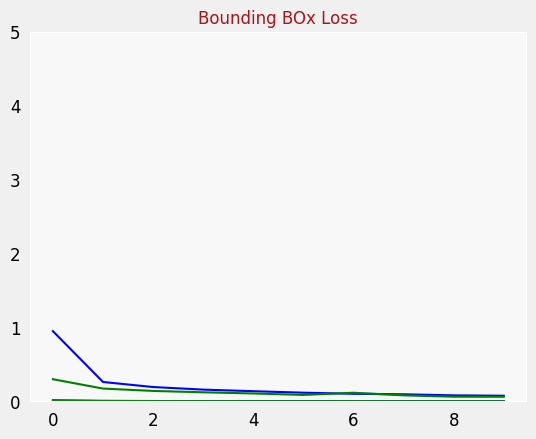

In [30]:
plot_metrics('classification_loss',"Classification Loss")
plot_metrics('bounding_box_loss',"Bounding BOx Loss")

## Intersection over union
Calculate IOU to evaluate model's performance

In [31]:
def intersection_over_union(pred_box,true_box):
  xmin_pred,ymin_pred,xmax_pred,ymax_pred = np.split(pred_box,4,axis=1)
  xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

  smoothing_factor = 1e-10

  xmin_overlap = np.maximum(xmin_pred, xmin_true)
  xmax_overlap = np.minimum(xmax_pred, xmax_true)
  ymin_overlap = np.maximum(ymin_pred, ymin_true)
  ymax_overlap = np.minimum(ymax_pred, ymax_true)

  pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
  true_box_area = (xmax_true - xmin_true) * (xmax_true - ymin_true)

  overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
  union_area = (pred_box_area + true_box_area) - overlap_area

  iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)
  return iou

## Visualize predictions

In [32]:
predictions = model.predict(validation_digits,batch_size=64)
predicted_labels = np.argmax(predictions[0],axis=1)

157/157 [==============================] - 1s 3ms/step


In [33]:
predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)
iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


Number of predictions where iou > threshold(0.6): 6149
Number of predictions where iou < threshold(0.6): 3851


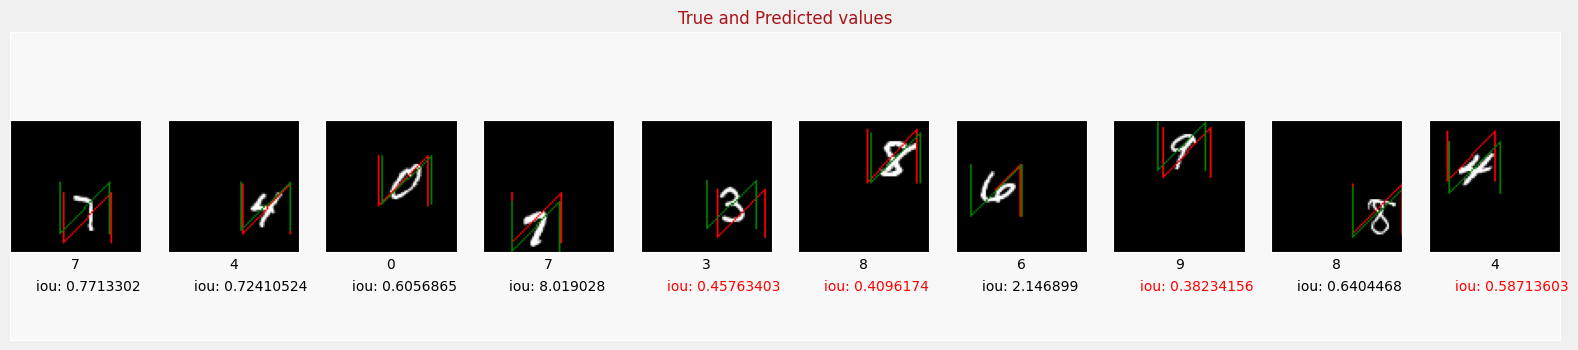

In [34]:
display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")